# Zeitreihenvorhersage mit ARIMA & Co



## Teil 1: Random walk, Autoregression (AR)

Einfache Autoregression AR(1)

Je nach Wahl von alpha erhält man ein *Random Walk* (alpha= 1) oder eine Zeitreihe, die sich einem weißen Rauschen annähert (alpha=0).

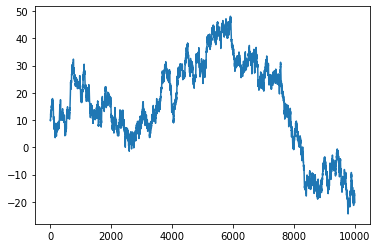

In [1]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(14)

size, alpha, const = 10000, 1, 10

myser = rng.uniform(-1,1,size=size)

arwalk = [const] # init values for up to AR(1)
for i in range (1, len(myser)):
    arwalk.append(myser[i] + alpha * arwalk[i-1])
    
plt.plot(arwalk)

Erweiterung der AR-Simulation. 

Statt nur eines Wertes nimmt die Funktion eine Liste von n Werten entgegen.
Aus AR(1) wird AR(n).x

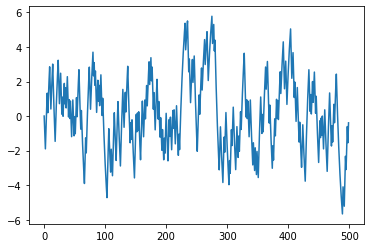

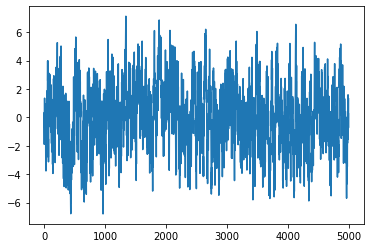

In [2]:
def arn(alpha=[1], size=100):
    """
    AR Simulation
    input: alpha =[xi]; length of list defines degree of AR-Simulation
    """
    global rng

    size=size
    alpha =  alpha
    AR = len(alpha)

    # noise
    myser= 2* rng.integers(0,2, size = size)-1

    arwalk = [0] * AR # initvalues for AR(AR)
    for i in range (AR, len(myser)):
        art = 0
        for j in range(AR):
            art += alpha[j] * arwalk[-j-1]
        arwalk.append(myser[i] + art)
    plt.plot(arwalk)
    plt.show()

    ds = pd.DataFrame({'AR': arwalk}).iloc[:,0]
    return ds


ds_ar1_9 = arn([0.9], 500) 
arn([0.9], 5000);


In [3]:
from sktime.forecasting.arima import ARIMA

#train / test split at position -split
split = 100 
y = ds_ar1_9[:-split]
y_test=ds_ar1_9[-split:]
forecaster = ARIMA(  
    order=(1, 0, 0),
    #seasonal_order=(0, 1, 0, 12), # needed later
    suppress_warnings=True)
forecaster.fit(y)  

fh = list(range(split))
y_pred = forecaster.predict(fh=fh)  
forecaster.get_fitted_params()

{'intercept': 0.03860793984983035,
 'ar.L1': 0.8738474003341504,
 'sigma2': 0.9940594749605028,
 'aic': 1140.2100209491853,
 'aicc': 1140.2706270097913,
 'bic': 1152.1844145905093,
 'hqic': 1144.9520362347346}

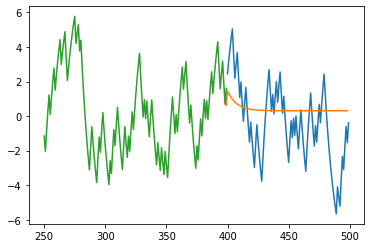

In [4]:
plt.plot(y_test)
plt.plot(y_pred)
plt.plot(y[-150:])

## Teil 2: Zeitreihenvorhersage an monosaisonalen Zeitreihen

### Laden der Beispieldaten

Die Schalter READDATA und WRITEDATA sollen daran erinnern, die Daten nur einmal zu lesen und zu speichern.

In [5]:
%reset -f

import pandas as pd
import matplotlib.pyplot as plt
import requests
from pathlib import Path

READDATA = False

url = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-{:02d}.parquet'
local_folder = 'data/'


for i in range(1,13):
    from_url = url.format(i)
    to_file = local_folder+Path(from_url).name
    #print(from_url, to_file)
    if READDATA:
        data = requests.get(from_url)
        open(to_file, 'wb').write(data.content)
    print(i, to_file, READDATA)
    
print('done')


1 data/green_tripdata_2022-01.parquet False
2 data/green_tripdata_2022-02.parquet False
3 data/green_tripdata_2022-03.parquet False
4 data/green_tripdata_2022-04.parquet False
5 data/green_tripdata_2022-05.parquet False
6 data/green_tripdata_2022-06.parquet False
7 data/green_tripdata_2022-07.parquet False
8 data/green_tripdata_2022-08.parquet False
9 data/green_tripdata_2022-09.parquet False
10 data/green_tripdata_2022-10.parquet False
11 data/green_tripdata_2022-11.parquet False
12 data/green_tripdata_2022-12.parquet False
done


In [6]:
# write date to file
WRITEDATA = False

fno = 'data/green_tripdata_all2022.gzip'

def clean_df(df, month, year = '2022'):
    """
    extract data from dataframe and restict time span to one month
    in: df, month (format: 01, ..12)
    out: df
    """

    df = df[['lpep_pickup_datetime']].copy()
    df.columns = ['pickup']
    df.set_index('pickup', inplace=True)
    df['trip'] = 1
    df.sort_index(inplace=True)
    period = year + '-' + month
    df= df[period:period]
    return df
    
    
dff = pd.DataFrame()
for i in range(1,13):
    from_url = url.format(i)
    to_file = local_folder+Path(from_url).name
    df = pd.read_parquet(to_file)
    month =  f'{i:02d}'
    df = clean_df(df, month)
    dff = pd.concat([dff, df], axis=0)
    print(month, df.shape)

if WRITEDATA:
    dff.to_parquet(fno, engine = 'fastparquet', compression='gzip')
    print('done')
    print(dff.shape)

dff.head(3)


01 (62491, 1)
02 (69376, 1)
03 (78513, 1)
04 (76101, 1)
05 (76874, 1)
06 (73709, 1)
07 (64188, 1)
08 (65915, 1)
09 (69016, 1)
10 (69309, 1)
11 (62289, 1)
12 (72423, 1)


,trip
pickup,
2022-01-01 00:00:17,1
2022-01-01 00:02:14,1
2022-01-01 00:02:43,1


### Vorbereiten der Daten

In [7]:
# forecast period
forecast_days = 28 

# daily frequency data
dd = dff.resample('d').agg('sum')
dd811 = dd['2022-08':'2022-10']

# simple splitting
y, y_test = dd811[:-forecast_days], dd811[-forecast_days:]

### Zeitreihenvorhersage

0 )  ARIMA(order=(2, 1, 2), seasonal_order=(0, 1, 0, 7), suppress_warnings=True)
{'intercept': -0.38466186782870704, 'ar.L1': -0.4466493585212971, 'ar.L2': 0.5270234017549058, 'ma.L1': -0.0016481308133499128, 'ma.L2': -0.9983475598348104, 'sigma2': 18772.059101568302, 'aic': 725.1154481318356, 'aicc': 726.8297338461213, 'bic': 737.2675582762465, 'hqic': 729.8267955354385}

1 )  AutoARIMA(max_p=3, max_q=3, sp=7, suppress_warnings=True)
{'intercept': 16.516318402538364, 'ar.L1': 0.4660390832969832, 'ma.S.L7': -0.6969729783855053, 'sigma2': 12368.31036273065, 'order': (1, 0, 0), 'seasonal_order': (0, 1, 1, 7), 'aic': 712.5081830409329, 'aicc': 713.2774138101636, 'bic': 720.6803881122711, 'hqic': 715.6841804106926}

2 )  ExponentialSmoothing(seasonal='multiplicative', sp=7, trend='add')
{'initial_level': 2091.3825274436904, 'initial_slope': None, 'initial_seasons': array([1.00902403, 1.04391819, 1.09331228, 1.12809157, 1.09678247,
       0.94565156, 0.81390512]), 'aic': 619.7140620494544, 

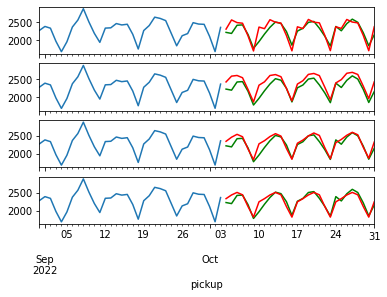

In [8]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.tbats import TBATS

forecaster1 = ARIMA(  
    order=(2, 1, 2),
    seasonal_order=(0, 1, 0, 7),
    suppress_warnings=True
    )

forecaster2 = AutoARIMA(
    sp=7, max_p=3, max_d=2, max_q=3,
    suppress_warnings=True
    )

forecaster3 = ExponentialSmoothing(
    trend='add', 
    seasonal='multiplicative', 
    sp=7
    )

forecaster4 = TBATS(  
    sp=7,
    n_jobs=1
    )


fc = [forecaster1, forecaster2, forecaster3, forecaster4]

fig, ax = plt.subplots(4,1, sharex=True)

for i,f in enumerate(fc):
    f.fit(y)  
    fh = list(range(1,forecast_days+1))
    y_pred = f.predict(fh=fh) 
    y[30:].plot(ax=ax[i], legend=False)
    y_test.plot(ax=ax[i], color='green', legend=False)
    y_pred.plot(ax=ax[i], color='red', legend=False)
    print(i, ') ', str(f))
    print(f.get_fitted_params(deep=True))
    print()
    
plt.show()
    

## Teil 3: Zeitreihenvorhersage an multisaisonalen Zeitreihen

### Dekomposition in Level, Trend, Saisonalität und Residuen

#### Laden der Beispieldaten

In [9]:
%reset -f

import pandas as pd
import matplotlib.pyplot as plt

fno = 'data/green_tripdata_all2022.gzip'

dff = pd.read_parquet(fno)

dh = dff.resample('h').agg('sum')
dh811 = dh['2022-08':'2022-10']

#### Dekomposition 1) Mono saisonal

Methode *seasonal_decompose*:

Kleine Modulationen überlagern den Trend, die Amplitude der Saisonalkomponente ist konstant, Schwankungen nimmt *residual* auf.

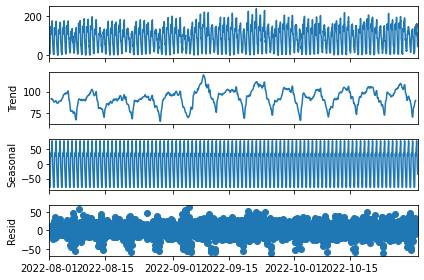

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_naive = seasonal_decompose(dh811) # period=)
result_naive.plot()
plt.show()

Methode *STL*

Trend erscheint geglättet, die Saisonalkomponente nimmt Schwankungen auf, *residual* fluktuiert sehr stark.

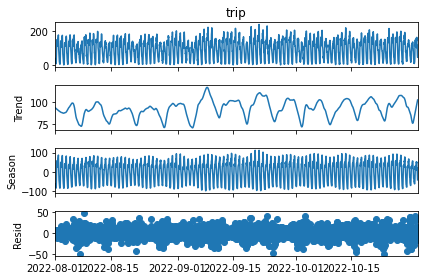

In [11]:
from statsmodels.tsa.seasonal import STL

dh811s = dh811['trip']

result_STL = STL(dh811s).fit()
result_STL.plot()
plt.show()


#### Dekomposition 2) Multi saisonal

Zweifache Anwendung der Decomposition


In [12]:
data = result_naive.resid + result_naive.trend
# remove nan values
data = data[15:-15]

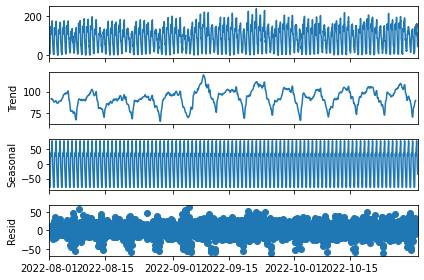

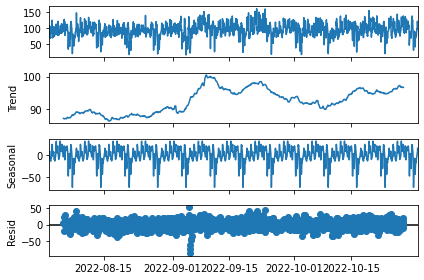

In [13]:
result2 = seasonal_decompose(data, period = 24*7)
result_naive.plot()
plt.show()
result2.plot()
plt.show()

### MSTL

Multiple seasonal trend decomposition using LOESS

statsmodels Vers >= .14

In [16]:
from statsmodels.tsa.seasonal import MSTL

model = MSTL(dh811, periods=(24, 24 * 7)) 
result_m = model.fit()

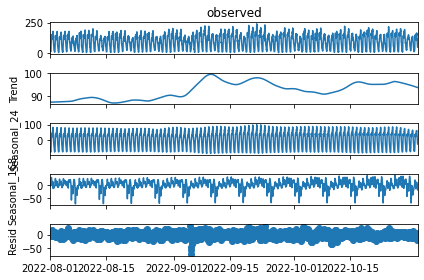

In [17]:
result_m.plot()
plt.show()

### TBATS

Analyse multisaisonaler Zeitreihen.

Demo-Datensatz enthält zwei Perioden: 24 h und 24 * 7 h.
Um die zweite Periode prominenter hervorzuheben, extrahieren wir über MSTL den langperiodischen saisonalen Anteil, glätten ihn und führen ihn nach einer Wichtung mit einem Faktor dem Ausgangsdatensatz zu.

In [1]:
# start with fresh notebook

In [2]:
%reset -f

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL

fno = 'data/green_tripdata_all2022.gzip'

dff = pd.read_parquet(fno)

dh = dff.resample('h').agg('sum')
dh811 = dh['2022-08':'2022-10']

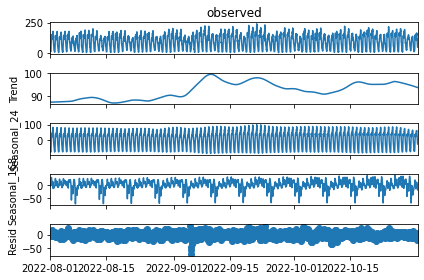

In [3]:
model = MSTL(dh811, periods=(24, 24 * 7))
result_m = model.fit()
result_m.plot()
plt.show()

<AxesSubplot: xlabel='pickup'>

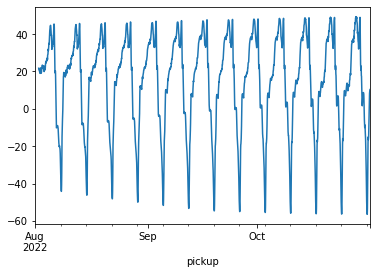

In [4]:
# Generate long period time series.
# shift level by "+5" and increase amplitude by "3"

emp = (result_m.seasonal.iloc[:,1].rolling(24).mean()+5)*3
emp.plot()

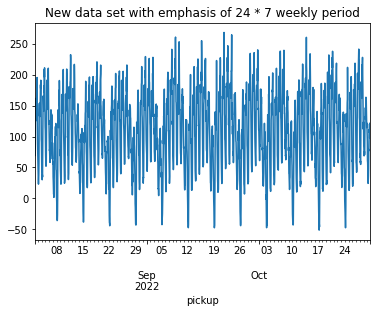

In [5]:
# create new dataset
dhemp = dh811['trip'] + emp
dhemp = dhemp[30:-30] #remove nan

dhemp.plot()
plt.title('New data set with emphasis of 24 * 7 weekly period')
plt.show()


In [6]:
from sktime.forecasting.tbats import TBATS

In [14]:
forecaster2 = TBATS(  
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=False,
    sp=[24, 24*7],
    use_arma_errors=False,
    n_jobs=1)

forecaster = TBATS(sp=[24, 24*7],)

In [15]:
forecast_days = 24*14 # 14 days
y_train = dhemp[:-forecast_days]


In [16]:
forecaster.fit(y_train)  

fh = list(range(1,forecast_days+1))
y_pred = forecaster.predict(fh=fh) 

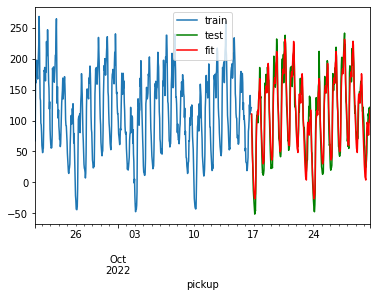

In [17]:
ax = y_train[1200:].plot()
dhemp[-forecast_days:].plot(ax=ax, color='green')
y_pred.plot(ax=ax, color='red')
plt.legend(['train', 'test', 'fit'])